#K-Means Model for Clustering the Soil Cover Classes Based on VPCA Dimension Reduction



The code constructs K_means clustering algorithm to processes the field reflectance data.The model partions the varimax rotated principal components of a field data into its original land cover type

Credits: Mohammed Braimah, September 2023


In [ ]:

##we are importing operational packages

import pandas as pd
import numpy as np
from google.colab import drive
drive.mount('/content/gdrive')

##we are importing visualization packages
import matplotlib.pyplot as plt
import seaborn as sns

# Important tools for modeling and evaluation.
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

Mounted at /content/gdrive


***We want to load the excel book and call each worksheet.
This saves us time from saving each worksheet seperately as a .csv file***

In [ ]:

VPCA = pd.ExcelFile('/content/gdrive/MyDrive/Field_Reflectance_Preprocessed/spring_2023_vpca_components.xlsx')

component = pd.read_excel(VPCA, 'Sheet1')
component = component.drop([59])


In [ ]:
component

,Sample,6VPCA Score 1,6VPCA Score 2,6VPCA Score 3,6VPCA Score 4,6VPCA Score 5,6VPCA Score 6
0,KB_5_Corn_Res_derivative,0.58711,1.45673,-0.78512,0.95528,0.85001,1.35848
1,KB_3_Corn_Res_derivative,0.47937,1.42302,-0.83547,1.16594,0.95517,0.77655
2,KB_1_Corn_Res_derivative,0.51947,1.47856,-0.84628,1.32242,1.13929,0.74541
3,JB_5_Corn_Res_derivative,0.22135,0.59156,-0.27654,-0.63017,0.09259,0.34682
4,JB_4_Corn_Res_derivative,-0.36003,-0.36478,-1.54492,-1.79321,-1.13306,0.53164
...,...,...,...,...,...,...,...
56,JanD_S10_Weeds_derivative,-0.16037,-0.77824,-0.10602,0.06051,0.77434,0.44745
57,JanD_S9_Weeds_derivative,-0.20803,-1.18310,0.10094,0.00556,1.22714,0.34596
58,ZachA_12_Wheat_derivative,-0.18920,-1.28749,-0.23878,0.01147,0.45827,0.27256
60,KB_5_Wheat_derivative,-0.26773,-1.34868,-0.64563,-0.80697,0.61665,0.38074


***We are begining the machine learning by cluster centres using K means***

In [ ]:
#We are assigning the visible spectrum to a variable called X. Remember we have set the wavelength column as index.
# The transposed matrix has wavelengths as column headings
X = component.drop('Sample', axis =1 )

In [ ]:
#We want to transform the data and save it to variable `X_scaled`.

X_scaled = StandardScaler().fit_transform(X)

***This Function is used to find an optimized cluster Centres. The Inertia which measures the squared distances of the intra-cluster distances are applied***

In [ ]:
# We fit K-means and evaluate inertia for different values of k.
num_clusters = [i for i in range(2, 12)]

def kmeans_inertia(num_clusters, x_vals):
    """
    Accepts as arguments list of ints and data array.
    Fits a KMeans model where k = each value in the list of ints.
    Returns each k-value's inertia appended to a list.
    """
    inertia = []
    for num in num_clusters:
        kms = KMeans(n_clusters=num, init='k-means++', n_init='auto', max_iter=1000, tol=0.0001, algorithm='lloyd', random_state=42)
        kms.fit(x_vals)
        inertia.append(kms.inertia_)

    return inertia

#model = KMeans.fit(X_scaled, k=2, random_state = 42)

In [ ]:
# We return a list of inertia for k=2 to 10.

inertia = kmeans_inertia(num_clusters, X_scaled)
inertia

[282.56739689383534,
 244.93575569423376,
 203.12752668279822,
 176.18587694349702,
 137.80290996094737,
 119.65264001591488,
 110.5411051108496,
 96.8296246035528,
 88.6857121234481,
 80.81302909050571]

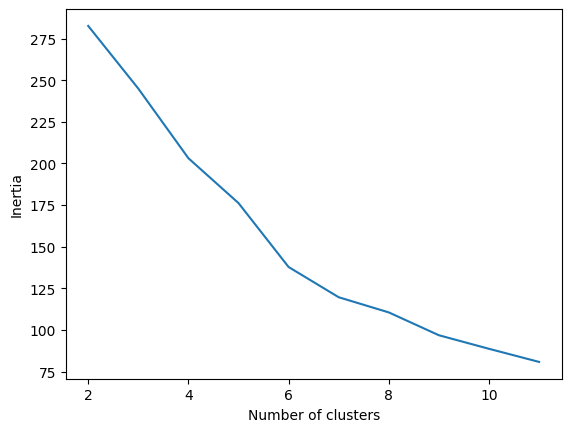

In [ ]:
#We want to plot the intertia curve
plot = sns.lineplot(x=num_clusters, y=inertia)
plot.set_xlabel("Number of clusters");
plot.set_ylabel("Inertia");

Wow!, The elbow of the intertia curves is around 3 cluster centres

***We want to use the Silhouette Score hyperparater to verfiy the the cluster centres. We do so by creating a function to calculate the silhouette scores***

In [ ]:
# We write a function to return a list of each k-value's score.
def kmeans_sil(num_clusters, x_vals):
    """
    Accepts as arguments list of ints and data array.
    Fits a KMeans model where k = each value in the list of ints.
    Calculates a silhouette score for each k value.
    Returns each k-value's silhouette score appended to a list.
    """
    sil_score = []
    for num in num_clusters:
        kms = KMeans(n_clusters=num, init='k-means++', n_init='auto', max_iter=1000, tol=0.0001, algorithm='lloyd', random_state=42)
        kms.fit(x_vals)
        sil_score.append(silhouette_score(x_vals, kms.labels_))

    return sil_score


sil_score = kmeans_sil(num_clusters, X_scaled)
sil_score

[0.24064683432964232,
 0.2226955785128655,
 0.26219278170589777,
 0.2458947307467138,
 0.302957009736,
 0.29479244416712586,
 0.31798868098225314,
 0.32614142907516724,
 0.3049511047833141,
 0.32109396107791505]

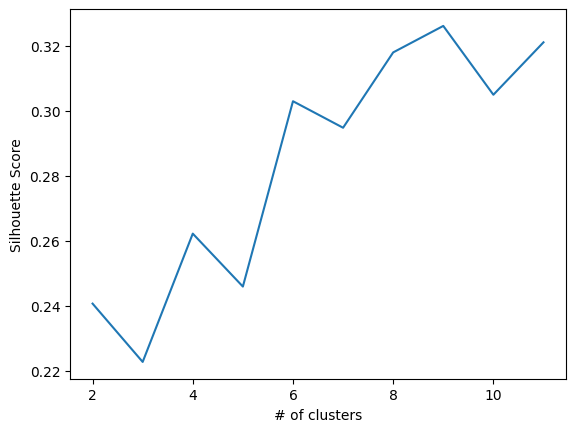

In [ ]:
# Create a line plot for the silhouette score.


plot = sns.lineplot(x=num_clusters, y=sil_score)
plot.set_xlabel("# of clusters");
plot.set_ylabel("Silhouette Score");

Congratulatings to us. We find that the optimal value of the Silhoutte score is 3. So we have 3 cluster centres

*** We now create the model with 3 cluster centres, and fit it to our X_scaled data***

In [ ]:
# Fit a 3-cluster model.

model = KMeans(n_clusters=6, init='k-means++', n_init='auto', max_iter=1000, tol=10000, algorithm='lloyd', random_state=42)
model.fit(X_scaled)

KMeans(max_iter=1000, n_clusters=6, n_init='auto', random_state=42, tol=10000)

In [ ]:
#We can now print the unique labels
print("Unique labels: ", np.unique(model.labels_))

Unique labels:  [0 1 2 3 4 5]


*** Now, Lets add a new column called clusters to our derivative reflectance and get the sizes of each cluster***

In [ ]:

component['cluster'] = model.labels_

In [ ]:
 #We want to verify the size of the cluster`.

component.groupby(by = ['cluster']).size()

cluster
0     7
1     7
2     9
3    13
4     9
5    16
dtype: int64

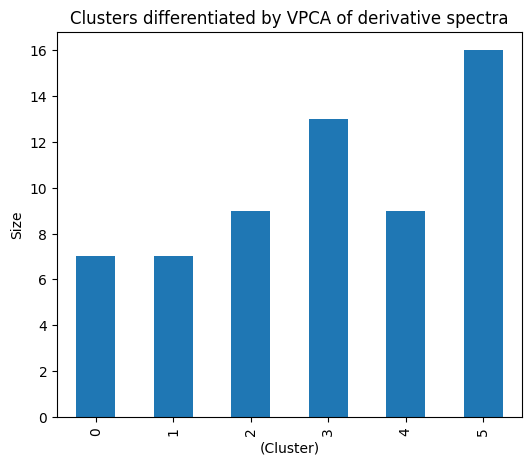

In [ ]:
#We want to plot the sizes of the cluster centers
component.groupby(by=['cluster']).size().plot.bar(title='Clusters differentiated by VPCA of derivative spectra',
                                                                   figsize=(6, 5),
                                                                   ylabel='Size',
                                                                   xlabel='(Cluster)');


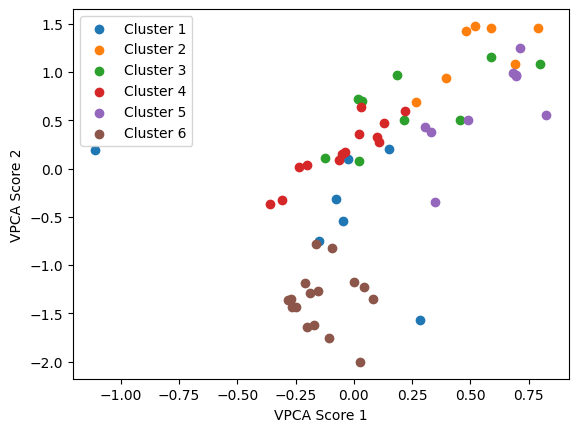

In [ ]:
for i in np.unique(model.labels_):
  plt.scatter(component[component['cluster'] == i]['6VPCA Score 1' ],component[component['cluster'] == i]['6VPCA Score 2' ] )
  #plt.scatter(components['cluster' == i, 1], components['cluster' == i, 2], cluster = i) # idf[label == i , 0] , df[label == i , 1] , label = i)
plt.xlabel('VPCA Score 1')
plt.ylabel('VPCA Score 2')
plt.legend(labels = ['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5', 'Cluster 6', 'Cluster 7' ])
plt.show()

In [ ]:
Cluster_1 = components[components['cluster']==0]
Cluster_1

,Sample,6VPCA Score 1,6VPCA Score 2,6VPCA Score 3,6VPCA Score 4,6VPCA Score 5,6VPCA Score 6,cluster
3,JB_5_Corn_Res_derivative,0.22135,0.59156,-0.27654,-0.63017,0.09259,0.34682,0
5,JB_3_Corn_Res_derivative,0.10088,0.33024,-0.12889,-0.98110,-0.49311,0.21719,0
11,LynnW_05_CornRes_derivative,0.13039,0.47146,-1.06606,-0.41610,0.06507,0.18301,0
14,LynnW_02_CornRes_derivative,0.02326,0.36264,-1.17524,-0.62427,0.04059,0.55469,0
16,KB_4_Dry_Rye_derivative,0.10936,0.27445,-0.98474,0.30089,-0.94334,0.96870,0
25,JanD_S8_Bare_Soil_derivative,0.03192,0.64042,-0.81841,0.35069,-0.38309,-0.13945,0
30,LynnW_05_Soil_derivative,-0.03934,0.17518,-0.63764,-0.48317,-0.99343,-0.25075,0
31,LynnW_04_Soil_derivative,-0.04935,0.14814,-0.59636,-0.55109,-0.23841,-1.18819,0
32,LynnW_03_Soil_derivative,-0.12356,0.11297,-0.57648,-0.91078,0.14304,-1.42339,0
33,LynnW_02_Soil_derivative,-0.06290,0.09099,-0.73817,-0.32865,-1.09834,-0.64372,0


In [ ]:
Cluster_2 = components[components['cluster']==1]
Cluster_2

,Sample,6VPCA Score 1,6VPCA Score 2,6VPCA Score 3,6VPCA Score 4,6VPCA Score 5,6VPCA Score 6,cluster
6,JB_2_Corn_Res_derivative,0.68073,0.99558,1.91077,-0.37851,0.29252,-0.04124,1
24,JB_0_Road_derivative,0.82569,0.55711,1.75469,-0.35000,-2.29446,2.39378,1
44,JB_5_Soil_derivative,0.33195,0.37671,1.08634,-1.02188,-1.07993,0.21160,1
45,JB_4_Soil_derivative,0.48866,0.49995,1.99945,-0.81329,-1.53388,0.30797,1
47,JB_2_Soil_derivative,0.69563,0.95687,2.47929,-0.66567,0.13843,-0.20964,1
48,JB_1_Soil_derivative,0.69685,0.97202,2.78105,-0.76941,0.22750,-0.39316,1
49,JB_1_Soya_Bean_derivative,0.34731,-0.34267,1.67154,-0.59478,0.44177,0.38146,1


In [ ]:
Cluster_3 = components[components['cluster']==2]
Cluster_3

,Sample,6VPCA Score 1,6VPCA Score 2,6VPCA Score 3,6VPCA Score 4,6VPCA Score 5,6VPCA Score 6,cluster
17,JB_Grass_Filt_derivative,-0.24803,-1.43721,-0.31468,-0.63768,1.22855,0.29335,2
18,SK_5_Grass_derivative,-0.20154,-1.63808,-0.08945,-0.04205,0.75973,0.18793,2
19,SK_4_Grass_derivative,-0.10447,-1.75455,0.28321,0.63363,0.82836,-0.11966,2
20,SK_3_Grass_derivative,-0.17191,-1.62548,-0.25792,-0.07938,0.48653,0.12025,2
21,SK_2_Grass_derivative,-0.28412,-1.36299,-0.57340,-0.50372,0.20397,0.32225,2
22,SK_1_Grass_derivative,-0.26351,-1.43892,-0.41211,-0.44106,0.52328,0.27347,2
23,ZachA_12_Road_derivative,-0.15460,-1.26814,-0.35687,-0.11656,0.76114,-0.35351,2
50,JanD_S6_Weed_derivative,0.04317,-1.23126,0.60679,0.77980,0.03040,0.55147,2
52,JanD_S6_Weed_3_derivative,0.02569,-2.00416,1.48579,1.74496,0.61252,1.07818,2
53,ZachA_15_Weeds_derivative,0.08321,-1.35619,0.75187,-0.53835,1.63487,0.06652,2


In [ ]:

Cluster_4 = components[components['cluster']==3]
Cluster_4

,Sample,6VPCA Score 1,6VPCA Score 2,6VPCA Score 3,6VPCA Score 4,6VPCA Score 5,6VPCA Score 6,cluster
4,JB_4_Corn_Res_derivative,-0.36003,-0.36478,-1.54492,-1.79321,-1.13306,0.53164,3
29,ZachA_11_Soil_derivative,-1.10787,0.18996,-0.20594,-0.66953,-3.02616,-0.42628,3
46,JB_3_Soil_derivative,-0.30734,-0.32592,-1.19419,-1.84323,-1.14022,0.39229,3
61,KB_5_Drying_Wheat_derivative,-0.14781,-0.75104,-0.69937,0.26585,-2.86606,0.51895,3


In [ ]:

Cluster_5 = components[components['cluster']==4]
Cluster_5

,Sample,6VPCA Score 1,6VPCA Score 2,6VPCA Score 3,6VPCA Score 4,6VPCA Score 5,6VPCA Score 6,cluster
35,SK_5_Soil_derivative,-0.07686,-0.31692,-0.33524,1.19890,-0.29101,-0.82981,4
36,SK_4_Soil_derivative,-0.02377,0.09830,-0.24788,1.81853,-1.07998,-1.15046,4
37,SK_3_Soil_derivative,0.15137,0.19895,-0.04729,3.72846,-1.37945,-1.74569,4
38,SK_2_Soil_derivative,-0.04729,-0.53887,-0.47901,1.49406,-0.91579,-1.06076,4
51,JanD_S6_Weed_2_derivative,0.28172,-1.57183,1.91510,2.72241,-1.20414,0.79381,4


In [ ]:
Cluster_6 = components[components['cluster']==5]
Cluster_6


,Sample,6VPCA Score 1,6VPCA Score 2,6VPCA Score 3,6VPCA Score 4,6VPCA Score 5,6VPCA Score 6,cluster
0,KB_5_Corn_Res_derivative,0.58711,1.45673,-0.78512,0.95528,0.85001,1.35848,5
1,KB_3_Corn_Res_derivative,0.47937,1.42302,-0.83547,1.16594,0.95517,0.77655,5
2,KB_1_Corn_Res_derivative,0.51947,1.47856,-0.84628,1.32242,1.13929,0.74541,5
7,JB_1_Corn_Res_derivative,0.71224,1.24818,0.79963,0.21658,0.96426,0.23944,5
8,JanD_S9_Corn_Res_derivative,0.26717,0.69057,-0.86472,0.33886,0.03211,0.98996,5
9,JanD_S8_Corn_Res_derivative,0.79154,1.46062,-0.46650,0.25406,0.10170,2.98642,5
10,JanD_S6_Corn_Rewd_derivative,0.69243,1.08887,-0.43473,0.43256,0.31608,2.43502,5
12,LynnW_04_CornRes_derivative,0.58994,1.16021,-0.71404,0.52023,1.66768,-1.04353,5
13,LynnW_03_CornRes_derivative,0.39453,0.93831,-0.94355,0.02916,0.77398,0.59516,5


In [ ]:
Cluster_7 = components[components['cluster']==6]
Cluster_7


,Sample,6VPCA Score 1,6VPCA Score 2,6VPCA Score 3,6VPCA Score 4,6VPCA Score 5,6VPCA Score 6,cluster
15,LynnW_01_CornRes_derivative,0.79962,1.08088,0.03101,0.04077,1.19361,-1.85869,6
26,ZachA_15_Soil_derivative,0.30610,0.43203,1.04386,-1.45887,0.59110,-1.13809,6
27,ZachA_14_Soil_derivative,0.21687,0.50350,1.05752,-1.10075,0.57432,-1.13913,6
28,ZachA_13_Soil_derivative,0.02198,0.07955,0.29294,-1.37950,0.17003,-1.26736,6
34,LynnW_01_Soil_derivative,0.45344,0.49939,0.77485,0.17617,-0.80337,-2.83282,6


In [ ]:
Cluster_8 = components[components['cluster']==7]
Cluster_8


,Sample,6VPCA Score 1,6VPCA Score 2,6VPCA Score 3,6VPCA Score 4,6VPCA Score 5,6VPCA Score 6,cluster


In [ ]:
Cluster_9 = components[components['cluster']==8]
Cluster_9


,Sample,6VPCA Score 1,6VPCA Score 2,6VPCA Score 3,6VPCA Score 4,6VPCA Score 5,6VPCA Score 6,cluster
17,JB_Grass_Filt_derivative,-0.24803,-1.43721,-0.31468,-0.63768,1.22855,0.29335,8
18,SK_5_Grass_derivative,-0.20154,-1.63808,-0.08945,-0.04205,0.75973,0.18793,8
19,SK_4_Grass_derivative,-0.10447,-1.75455,0.28321,0.63363,0.82836,-0.11966,8
20,SK_3_Grass_derivative,-0.17191,-1.62548,-0.25792,-0.07938,0.48653,0.12025,8
21,SK_2_Grass_derivative,-0.28412,-1.36299,-0.57340,-0.50372,0.20397,0.32225,8
22,SK_1_Grass_derivative,-0.26351,-1.43892,-0.41211,-0.44106,0.52328,0.27347,8
23,ZachA_12_Road_derivative,-0.15460,-1.26814,-0.35687,-0.11656,0.76114,-0.35351,8
53,ZachA_15_Weeds_derivative,0.08321,-1.35619,0.75187,-0.53835,1.63487,0.06652,8
54,ZachA_14_Weeds_derivative,-0.09176,-0.82371,-0.11610,-0.74022,0.05172,-0.03655,8
55,ZachA_13_Weeds_derivative,-0.00010,-1.17564,0.48237,0.00453,0.44824,-0.02667,8


In [ ]:
Cluster_10 = components[components['cluster']==9]
Cluster_10


,Sample,6VPCA Score 1,6VPCA Score 2,6VPCA Score 3,6VPCA Score 4,6VPCA Score 5,6VPCA Score 6,cluster
4,JB_4_Corn_Res_derivative,-0.36003,-0.36478,-1.54492,-1.79321,-1.13306,0.53164,9
46,JB_3_Soil_derivative,-0.30734,-0.32592,-1.19419,-1.84323,-1.14022,0.39229,9
61,KB_5_Drying_Wheat_derivative,-0.14781,-0.75104,-0.69937,0.26585,-2.86606,0.51895,9


#SUMMARY REPORT
The model does a good job at clustering the VPCA of the field data into its original field cover. Hoever, there are a lot of overlaps in the clusters.
